In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import definitive_dyn_indicators.scripts.data_manager as dm
import os
from tqdm.auto import tqdm
from numba import njit
import lmfit
import joblib
from joblib import Parallel, delayed
import pandas as pd

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

# count number of threads
njobs = os.cpu_count()
print(f'Number of threads: {njobs}')

Number of threads: 20


In [101]:
DATA_DIR = "./data"
SAMPLES = 100

T_GROUND_TRUTH = 100000000
T_NORMALIZATION = 1000
T_DYN_INDICATORS = 1000000

group = (
    0.310,                  # omega_x
    0.320,                  # omega_y
    "sps",                  # modulation_kind
    0.0,                   # epsilon
    0.00,                   # mu
    np.nan,                 # kick amplitude
    np.nan,                 # omega_0
)

group_random = tuple(
    [group[i] if i != 5 else 1e-10 for i in range(len(group))])

X_EXTENTS = [0.0, 0.23]
Y_EXTENTS = [0.0, 0.23]


In [102]:
data = dm.data_manager(data_dir=DATA_DIR)

data.henon_config["samples"] = SAMPLES
data.henon_config["x_extents"] = X_EXTENTS
data.henon_config["y_extents"] = Y_EXTENTS

data.henon_config["t_base_2"] = np.array([], dtype=int)
data.henon_config["t_base"] = np.array([], dtype=int)
data.henon_config["t_base_10"] = np.logspace(
    int(np.log10(T_NORMALIZATION)),
    int(np.log10(T_GROUND_TRUTH)),
    int(np.log10(T_GROUND_TRUTH)) - int(np.log10(T_NORMALIZATION)) + 1,
    base=10, dtype=int)
data.henon_config["t_linear"] = np.array([], dtype=int)

data.henon_config = dm.refresh_henon_config(data.henon_config)

config = data.get_config()
extents = config["x_extents"] + config["y_extents"]
samples = config["samples"]

times = np.asarray(data.get_times())


In [103]:
full_lyapunov = data.fast_lyapunov_indicator(group)

Getting file for group (0.31, 0.32, 'sps', 0.0, 0.0, nan, nan) with displacement none and tracking lyapunov!


100%|██████████| 6/6 [00:00<00:00, 326.83it/s]


In [104]:
with data.get_file_from_group(group, "none", "lyapunov") as f:
    stability = f["steps"][:]
stability = stability[:len(stability)//2]
stab_mask = ~np.isnan(full_lyapunov[T_GROUND_TRUTH].to_numpy())


Getting file for group (0.31, 0.32, 'sps', 0.0, 0.0, nan, nan) with displacement none and tracking lyapunov!


In [105]:
data_minor = dm.data_manager(
    data_dir=os.path.join(DATA_DIR, "10_6"))

data_minor.henon_config["samples"] = SAMPLES
data_minor.henon_config["x_extents"] = X_EXTENTS
data_minor.henon_config["y_extents"] = Y_EXTENTS

data_minor.henon_config["t_base_2"] = np.array([], dtype=int)
data_minor.henon_config["t_base"] = np.arange(
    T_NORMALIZATION, T_DYN_INDICATORS + T_NORMALIZATION, T_NORMALIZATION, dtype=int)

data_minor.henon_config["t_base_10"] = np.array([], dtype=int)
data_minor.henon_config["t_linear"] = np.array([], dtype=int)

data_minor.henon_config = dm.refresh_henon_config(data_minor.henon_config)


In [106]:
times_minor = np.asarray(data_minor.get_times())


In [8]:
gali = data_minor.global_alignment_index(group)


Getting file for group (0.31, 0.32, 'sps', 64.0, 0.0, nan, nan) with displacement none and tracking gali!


100%|██████████| 1000/1000 [00:01<00:00, 564.81it/s]


In [9]:
sali = data_minor.smallest_alignment_index(group)


Getting file for group (0.31, 0.32, 'sps', 64.0, 0.0, nan, nan) with displacement none and tracking sali!


100%|██████████| 1000/1000 [00:01<00:00, 607.50it/s]


In [10]:
lyapunov = data_minor.fast_lyapunov_indicator(group)


Getting file for group (0.31, 0.32, 'sps', 64.0, 0.0, nan, nan) with displacement none and tracking lyapunov!


100%|██████████| 1000/1000 [00:03<00:00, 271.56it/s]


In [11]:
ortho_lyap_max, ortho_lyap_avg = data_minor.orthogonal_lyapunov_indicator(group)

Getting file for group (0.31, 0.32, 'sps', 64.0, 0.0, nan, nan) with displacement none and tracking orthogonal_lyapunov!


100%|██████████| 1000/1000 [00:12<00:00, 82.42it/s]


In [107]:
reverse = data_minor.reversibility_error(group)

Getting file for group (0.31, 0.32, 'sps', 0.0, 0.0, nan, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 1000/1000 [00:09<00:00, 101.71it/s]


In [109]:
reverse[1000000].to_numpy()

array([0.00000000e+00, 2.81296295e-13, 1.50727787e-12, ...,
                  nan,            nan,            nan])

In [113]:
for n in [1000, 3000, 10000, 30000, 100000, 300000, 1000000]:
    print(np.nanmax(np.log10(reverse[n].to_numpy())), np.nanmin(np.log10(reverse[n].to_numpy())))

-6.2888457853442095 -inf
-0.4168539607444367 -inf
-0.32277059348058745 -inf
-0.3405244446690755 -inf
-0.37695290705554 -inf
-0.3490653185155284 -inf
-0.3161845380065095 -inf


/tmp/ipykernel_10113/123169531.py:2: RuntimeWarning: divide by zero encountered in log10
  print(np.nanmax(np.log10(reverse[n].to_numpy())), np.nanmin(np.log10(reverse[n].to_numpy())))


In [ ]:
#reverse_kick = data_minor.reversibility_error(group_random)

In [13]:
data_tune = dm.data_manager(
    data_dir=os.path.join(DATA_DIR, "10_6"))

data_tune.henon_config["samples"] = SAMPLES
data_tune.henon_config["x_extents"] = X_EXTENTS
data_tune.henon_config["y_extents"] = Y_EXTENTS

# find the closest power of 2 to T_DYN_INDICATORS
t_tune_pow = np.ceil(np.log2(T_DYN_INDICATORS)) + 2
t_tune_min = 4

data_tune.henon_config["t_base_2"] = 2 ** np.arange(t_tune_min, t_tune_pow + 1, dtype=int)
data_tune.henon_config["t_base"] = np.array([], dtype=int)
data_tune.henon_config["t_base_10"] = np.array([], dtype=int)
data_tune.henon_config["t_linear"] = np.array([], dtype=int)

data_tune.henon_config = dm.refresh_henon_config(data_tune.henon_config)

times_tune = np.asarray(data_tune.get_times())


In [14]:
tunes = data_tune.birkhoff_tunes(group)

Getting file for group (0.31, 0.32, 'sps', 64.0, 0.0, nan, nan) with displacement none and tracking birkhoff_tunes!


# PLOT FULL LYAPUNOV...

In [51]:
TIMES = times
DATA = full_lyapunov

In [52]:
def cover_extreme_outliers(data, m=10):
    """
    Cover extreme outliers in data.
    """
    data_mean = np.nanmean(data)
    data_std = np.nanstd(data)
    data_min = data_mean - m * data_std
    data_max = data_mean + m * data_std
    data_mask = np.logical_and(data >= data_min, data <= data_max)
    data[~data_mask] = np.nan
    return data

In [53]:
val_min = np.nan
val_max = np.nan
for k in DATA.keys():
    d = np.log10(DATA[k].to_numpy())[stab_mask]
    d = cover_extreme_outliers(d)
    val_min = np.nanmin([val_min, np.nanmin(d)])
    val_max = np.nanmax([val_max, np.nanmax(d)])
print(val_min, val_max)

-8.495361365233075 -2.2948946136616994


/tmp/ipykernel_10113/302532080.py:4: RuntimeWarning: invalid value encountered in log10
  d = np.log10(DATA[k].to_numpy())[stab_mask]


In [54]:
count, bins = np.histogram(np.log10(DATA[1000000].to_numpy()),
             bins=50, range=(val_min, val_max))

bin_centers = (bins[:-1] + bins[1:]) / 2

/tmp/ipykernel_10113/3224112554.py:1: RuntimeWarning: invalid value encountered in log10
  count, bins = np.histogram(np.log10(DATA[1000000].to_numpy()),


In [55]:
nbins = 50
count_map = np.zeros((len(TIMES), nbins))

for i, k in enumerate(DATA.keys()):
    d = np.log10(DATA[k].to_numpy())[stab_mask]
    count, bins = np.histogram(d, bins=50, range=(val_min, val_max), density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    count_map[i, :] = count

count_map[count_map==0] = np.nan

/tmp/ipykernel_10113/1417517132.py:5: RuntimeWarning: invalid value encountered in log10
  d = np.log10(DATA[k].to_numpy())[stab_mask]


/tmp/ipykernel_10113/2008986382.py:26: RuntimeWarning: invalid value encountered in log10
  axs["hist2"].hist(np.log10(DATA[TIMES[len(TIMES)//2]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
/tmp/ipykernel_10113/2008986382.py:27: RuntimeWarning: invalid value encountered in log10
  axs["hist3"].hist(np.log10(DATA[TIMES[0]].to_numpy()), bins=50, range=(val_min, val_max), density=True)


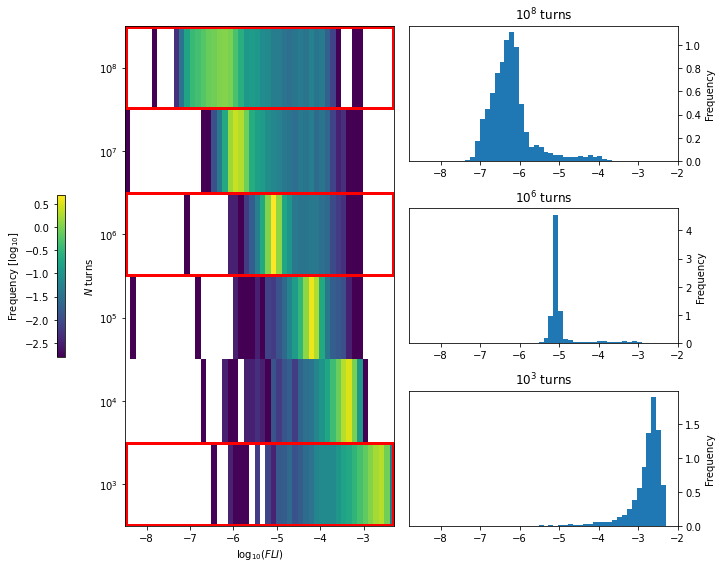

In [56]:
fig = plt.figure(figsize=(10, 8))
# fig, axs = plt.subplot_mosaic(
#     [["cbar","cmap","cmap","cmap","cmap", "hist1","hist1","hist1"],
#      ["cbar","cmap","cmap","cmap","cmap", "hist2","hist2","hist2"],
#      ["cbar", "cmap", "cmap", "cmap","cmap", "hist3", "hist3", "hist3"]],
#     figsize=(10, 10))

gs = GridSpec(3, 3, figure=fig, width_ratios=[0.2, 1, 1])
axs = {}
axs["cmap"] = fig.add_subplot(gs[:, 1])
axs["cbar"] = fig.add_subplot(gs[:, 0])
axs["hist1"] = fig.add_subplot(gs[0, 2])
axs["hist2"] = fig.add_subplot(gs[1, 2])
axs["hist3"] = fig.add_subplot(gs[2, 2])

mappable = axs["cmap"].imshow(np.log10(count_map), aspect="auto", interpolation="nearest", extent=(val_min, val_max, 0, len(TIMES)), origin="lower")


axs["cmap"].set_xlabel("$\\log_{{10}}(FLI)$")
axs["cmap"].set_ylabel("$N$ turns")
# set the ticks on the y axis to be the times
plt.sca(axs["cmap"])
plt.yticks(np.arange(len(TIMES))+0.5, [f"$10^{int(np.log10(t))}$" for t in TIMES])

axs["hist1"].hist(np.log10(DATA[TIMES[-1]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
axs["hist2"].hist(np.log10(DATA[TIMES[len(TIMES)//2]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
axs["hist3"].hist(np.log10(DATA[TIMES[0]].to_numpy()), bins=50, range=(val_min, val_max), density=True)

axs["hist1"].set_ylabel("Frequency")
axs["hist2"].set_ylabel("Frequency")
axs["hist3"].set_ylabel("Frequency")
# move ylabels to the right
axs["hist1"].yaxis.tick_right()
axs["hist2"].yaxis.tick_right()
axs["hist3"].yaxis.tick_right()
# move y title to the right
axs["hist1"].yaxis.set_label_position("right")
axs["hist2"].yaxis.set_label_position("right")
axs["hist3"].yaxis.set_label_position("right")

# set titles for the histos
axs["hist1"].set_title(f"$10^{int(np.log10(TIMES[-1]))}$ turns")
axs["hist2"].set_title(f"$10^{int(np.log10(TIMES[len(TIMES)//2]))}$ turns")
axs["hist3"].set_title(f"$10^{int(np.log10(TIMES[0]))}$ turns")

d_rect_x = (val_max - val_min) * 0.005
d_rect_y = 0.01
rect = patches.Rectangle((val_min+d_rect_x, len(TIMES)-1+d_rect_y), val_max -
                         val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)

rect = patches.Rectangle((val_min+d_rect_x, 0+d_rect_y), val_max - val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)


rect = patches.Rectangle((val_min+d_rect_x, len(TIMES)//2+d_rect_y), val_max - val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)


# clear completely axs["cbar"]
fig.delaxes(axs["cbar"])

# create colorbar with height equal to axs["cmap"]
fig.colorbar(mappable, ax=axs["cbar"],
             location="left", label="Frequency $[\\log_{10}]$", aspect=20)
plt.tight_layout()

plt.savefig("figs/fli_hist.jpg", dpi=300)


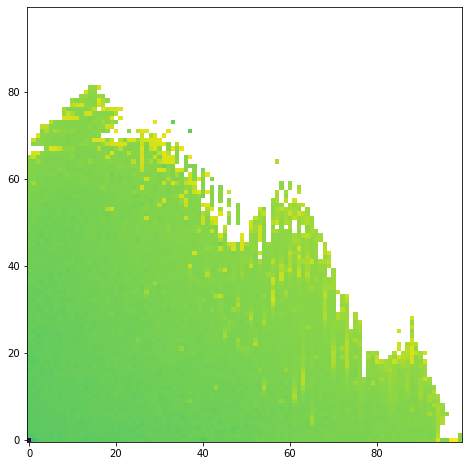

In [57]:
plt.figure(figsize=(10, 8))
plt.imshow(np.log10(full_lyapunov[100000000].to_numpy()).reshape(samples, samples), origin="lower")

# THE PLOT

In [60]:
TIMES = times_minor
DATA = lyapunov

In [93]:
picked_times = [
    1000, 3000,
    10000, 30000,
    100000, 300000,
    1000000
]
corresponding_indexes = [
    np.where(TIMES == t)[0][0] for t in picked_times
]

labels = [
    "$1\\times 10^3$", "$3\\times 10^3$",
    "$1\\times 10^4$", "$3\\times 10^4$",
    "$1\\times 10^5$", "$3\\times 10^5$",
    "$1\\times 10^6$"
]

In [94]:
def cover_extreme_outliers(data, m=10):
    """
    Cover extreme outliers in data.
    """
    data_mean = np.nanmean(data)
    data_std = np.nanstd(data)
    data_min = data_mean - m * data_std
    data_max = data_mean + m * data_std
    data_mask = np.logical_and(data >= data_min, data <= data_max)
    data[~data_mask] = np.nan
    return data

In [95]:
val_min = np.nan
val_max = np.nan
for k in picked_times:
    d = np.log10(DATA[k].to_numpy())[stab_mask]
    d = cover_extreme_outliers(d)
    val_min = np.nanmin([val_min, np.nanmin(d)])
    val_max = np.nanmax([val_max, np.nanmax(d)])
print(val_min, val_max)


-7.063406626659475 -1.7089304653540576


/tmp/ipykernel_10113/4147483705.py:4: RuntimeWarning: invalid value encountered in log10
  d = np.log10(DATA[k].to_numpy())[stab_mask]


In [96]:
count, bins = np.histogram(np.log10(DATA[1000000].to_numpy()),
             bins=50, range=(val_min, val_max))

bin_centers = (bins[:-1] + bins[1:]) / 2

/tmp/ipykernel_10113/3224112554.py:1: RuntimeWarning: invalid value encountered in log10
  count, bins = np.histogram(np.log10(DATA[1000000].to_numpy()),


In [97]:
nbins = 50
count_map = np.zeros((len(picked_times), nbins))

for i, k in enumerate(picked_times):
    d = np.log10(DATA[k].to_numpy())[stab_mask]
    count, bins = np.histogram(d, bins=50, range=(val_min, val_max), density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    count_map[i, :] = count

count_map[count_map==0] = np.nan


/tmp/ipykernel_10113/67871865.py:5: RuntimeWarning: invalid value encountered in log10
  d = np.log10(DATA[k].to_numpy())[stab_mask]


/tmp/ipykernel_10113/3797179249.py:25: RuntimeWarning: invalid value encountered in log10
  axs["hist1"].hist(np.log10(DATA[picked_times[-1]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
/tmp/ipykernel_10113/3797179249.py:26: RuntimeWarning: invalid value encountered in log10
  axs["hist2"].hist(np.log10(DATA[picked_times[len(picked_times)//2]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
/tmp/ipykernel_10113/3797179249.py:27: RuntimeWarning: invalid value encountered in log10
  axs["hist3"].hist(np.log10(DATA[picked_times[0]].to_numpy()), bins=50, range=(val_min, val_max), density=True)


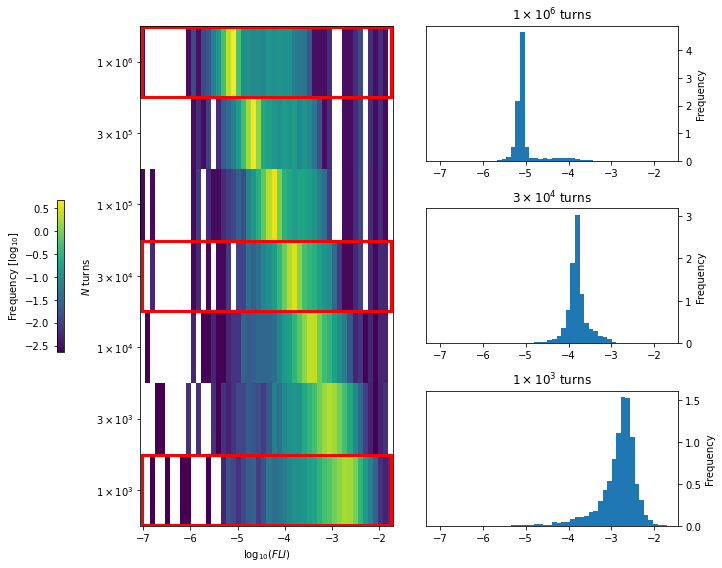

In [99]:
fig = plt.figure(figsize=(10, 8))
# fig, axs = plt.subplot_mosaic(
#     [["cbar","cmap","cmap","cmap","cmap", "hist1","hist1","hist1"],
#      ["cbar","cmap","cmap","cmap","cmap", "hist2","hist2","hist2"],
#      ["cbar", "cmap", "cmap", "cmap","cmap", "hist3", "hist3", "hist3"]],
#     figsize=(10, 10))

gs = GridSpec(3, 3, figure=fig, width_ratios=[0.2, 1, 1])
axs = {}
axs["cmap"] = fig.add_subplot(gs[:, 1])
axs["cbar"] = fig.add_subplot(gs[:, 0])
axs["hist1"] = fig.add_subplot(gs[0, 2])
axs["hist2"] = fig.add_subplot(gs[1, 2])
axs["hist3"] = fig.add_subplot(gs[2, 2])

mappable = axs["cmap"].imshow(np.log10(count_map), aspect="auto", interpolation="nearest", extent=(val_min, val_max, 0, len(picked_times)), origin="lower")


axs["cmap"].set_xlabel("$\\log_{{10}}(FLI)$")
axs["cmap"].set_ylabel("$N$ turns")
# set the ticks on the y axis to be the times
plt.sca(axs["cmap"])
plt.yticks(np.arange(len(picked_times))+0.5, labels)

axs["hist1"].hist(np.log10(DATA[picked_times[-1]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
axs["hist2"].hist(np.log10(DATA[picked_times[len(picked_times)//2]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
axs["hist3"].hist(np.log10(DATA[picked_times[0]].to_numpy()), bins=50, range=(val_min, val_max), density=True)

axs["hist1"].set_ylabel("Frequency")
axs["hist2"].set_ylabel("Frequency")
axs["hist3"].set_ylabel("Frequency")
# move ylabels to the right
axs["hist1"].yaxis.tick_right()
axs["hist2"].yaxis.tick_right()
axs["hist3"].yaxis.tick_right()
# move y title to the right
axs["hist1"].yaxis.set_label_position("right")
axs["hist2"].yaxis.set_label_position("right")
axs["hist3"].yaxis.set_label_position("right")

# set titles for the histos
axs["hist1"].set_title(f"{labels[-1]} turns")
axs["hist2"].set_title(f"{labels[len(picked_times)//2]} turns")
axs["hist3"].set_title(f"{labels[0]} turns")

d_rect_x = (val_max - val_min) * 0.005
d_rect_y = 0.01
rect = patches.Rectangle((val_min+d_rect_x, len(picked_times)-1+d_rect_y), val_max -
                         val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)

rect = patches.Rectangle((val_min+d_rect_x, 0+d_rect_y), val_max - val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)


rect = patches.Rectangle((val_min+d_rect_x, len(picked_times)//2+d_rect_y), val_max -
                         val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)


# clear completely axs["cbar"]
fig.delaxes(axs["cbar"])

# create colorbar with height equal to axs["cmap"]
fig.colorbar(mappable, ax=axs["cbar"],
             location="left", label="Frequency $[\\log_{10}]$", aspect=20)
plt.tight_layout()

plt.savefig("figs/fli_hist.jpg", dpi=300)


# TUNES

In [114]:
TIMES = times_tune
DATA = tunes

In [115]:
TIMES

array([     16,      32,      64,     128,     256,     512,    1024,
          2048,    4096,    8192,   16384,   32768,   65536,  131072,
        262144,  524288, 1048576, 2097152, 4194304])

In [116]:
picked_times = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072
]
corresponding_indexes = [
    np.where(TIMES == t)[0][0] for t in picked_times
]

labels = [f"${t}$" for t in picked_times]


In [117]:
def cover_extreme_outliers(data, m=10):
    """
    Cover extreme outliers in data.
    """
    data_mean = np.nanmean(data)
    data_std = np.nanstd(data)
    data_min = data_mean - m * data_std
    data_max = data_mean + m * data_std
    data_mask = np.logical_and(data >= data_min, data <= data_max)
    data[~data_mask] = np.nan
    return data

In [118]:
val_min = np.nan
val_max = np.nan
for k in picked_times:
    d = np.log10(DATA[k].to_numpy())[stab_mask]
    d = cover_extreme_outliers(d)
    val_min = np.nanmin([val_min, np.nanmin(d)])
    val_max = np.nanmax([val_max, np.nanmax(d)])
print(val_min, val_max)


-15.653559774527022 -1.329112084651185


/tmp/ipykernel_10113/4147483705.py:4: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(DATA[k].to_numpy())[stab_mask]
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/tmp/ipykernel_10113/4147483705.py:6: RuntimeWarning: All-NaN slice encountered
  val_min = np.nanmin([val_min, np.nanmin(d)])
/tmp/ipykernel_10113/4147483705.py:6: RuntimeWarning: All-NaN axis encountered
  val_min = np.nanmin([val_min, np.nanmin(d)])
/tmp/ipykernel_10113/4147483705.py:7: RuntimeWarning: All-NaN slice encountered
  val_max = np.nanmax([val_max, np.nanmax(d)])
/tmp/ipykernel_10113/4147483705.py:7: RuntimeWarning: All-NaN axis encountered
  val_max = np.nanmax([val_max, np.nanmax(d)])


In [121]:
count, bins = np.histogram(np.log10(DATA[picked_times[-1]].to_numpy()),
             bins=50, range=(val_min, val_max))

bin_centers = (bins[:-1] + bins[1:]) / 2

In [122]:
nbins = 50
count_map = np.zeros((len(picked_times), nbins))

for i, k in enumerate(picked_times):
    d = np.log10(DATA[k].to_numpy())[stab_mask]
    count, bins = np.histogram(d, bins=50, range=(val_min, val_max), density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    count_map[i, :] = count

count_map[count_map==0] = np.nan


/tmp/ipykernel_10113/67871865.py:5: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(DATA[k].to_numpy())[stab_mask]


/tmp/ipykernel_10113/3797179249.py:27: RuntimeWarning: divide by zero encountered in log10
  axs["hist3"].hist(np.log10(DATA[picked_times[0]].to_numpy()), bins=50, range=(val_min, val_max), density=True)


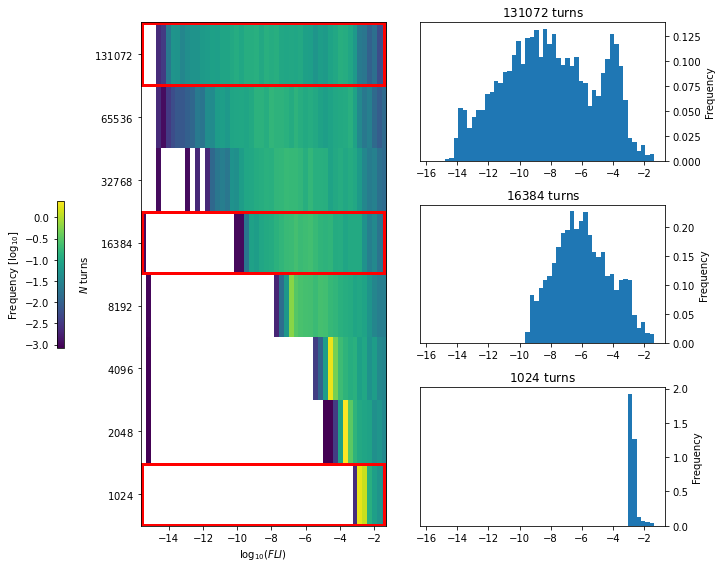

In [123]:
fig = plt.figure(figsize=(10, 8))
# fig, axs = plt.subplot_mosaic(
#     [["cbar","cmap","cmap","cmap","cmap", "hist1","hist1","hist1"],
#      ["cbar","cmap","cmap","cmap","cmap", "hist2","hist2","hist2"],
#      ["cbar", "cmap", "cmap", "cmap","cmap", "hist3", "hist3", "hist3"]],
#     figsize=(10, 10))

gs = GridSpec(3, 3, figure=fig, width_ratios=[0.2, 1, 1])
axs = {}
axs["cmap"] = fig.add_subplot(gs[:, 1])
axs["cbar"] = fig.add_subplot(gs[:, 0])
axs["hist1"] = fig.add_subplot(gs[0, 2])
axs["hist2"] = fig.add_subplot(gs[1, 2])
axs["hist3"] = fig.add_subplot(gs[2, 2])

mappable = axs["cmap"].imshow(np.log10(count_map), aspect="auto", interpolation="nearest", extent=(val_min, val_max, 0, len(picked_times)), origin="lower")


axs["cmap"].set_xlabel("$\\log_{{10}}(FLI)$")
axs["cmap"].set_ylabel("$N$ turns")
# set the ticks on the y axis to be the times
plt.sca(axs["cmap"])
plt.yticks(np.arange(len(picked_times))+0.5, labels)

axs["hist1"].hist(np.log10(DATA[picked_times[-1]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
axs["hist2"].hist(np.log10(DATA[picked_times[len(picked_times)//2]].to_numpy()), bins=50, range=(val_min, val_max), density=True)
axs["hist3"].hist(np.log10(DATA[picked_times[0]].to_numpy()), bins=50, range=(val_min, val_max), density=True)

axs["hist1"].set_ylabel("Frequency")
axs["hist2"].set_ylabel("Frequency")
axs["hist3"].set_ylabel("Frequency")
# move ylabels to the right
axs["hist1"].yaxis.tick_right()
axs["hist2"].yaxis.tick_right()
axs["hist3"].yaxis.tick_right()
# move y title to the right
axs["hist1"].yaxis.set_label_position("right")
axs["hist2"].yaxis.set_label_position("right")
axs["hist3"].yaxis.set_label_position("right")

# set titles for the histos
axs["hist1"].set_title(f"{labels[-1]} turns")
axs["hist2"].set_title(f"{labels[len(picked_times)//2]} turns")
axs["hist3"].set_title(f"{labels[0]} turns")

d_rect_x = (val_max - val_min) * 0.005
d_rect_y = 0.01
rect = patches.Rectangle((val_min+d_rect_x, len(picked_times)-1+d_rect_y), val_max -
                         val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)

rect = patches.Rectangle((val_min+d_rect_x, 0+d_rect_y), val_max - val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)


rect = patches.Rectangle((val_min+d_rect_x, len(picked_times)//2+d_rect_y), val_max -
                         val_min-d_rect_x*2, 1-d_rect_y*2, linewidth=3, edgecolor='r', facecolor='none')
axs["cmap"].add_patch(rect)


# clear completely axs["cbar"]
fig.delaxes(axs["cbar"])

# create colorbar with height equal to axs["cmap"]
fig.colorbar(mappable, ax=axs["cbar"],
             location="left", label="Frequency $[\\log_{10}]$", aspect=20)
plt.tight_layout()

plt.savefig("figs/fli_hist.jpg", dpi=300)


# PERFORMANCES

(array([  1.,   0.,   0.,   0.,   2.,  13.,  81., 186., 262., 278., 392.,
        483., 576., 660., 811., 772., 688., 616., 448., 285., 164.,  98.,
         45.,  47.,  10.,  13.,   4.,   3.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   1.,   3.,   0.,   2.,   3.,
          7.,   5.,  16.,  20.,  15.,  20.]),
 array([-7.84377519, -7.72818232, -7.61258945, -7.49699657, -7.3814037 ,
        -7.26581083, -7.15021796, -7.03462509, -6.91903222, -6.80343934,
        -6.68784647, -6.5722536 , -6.45666073, -6.34106786, -6.22547499,
        -6.10988212, -5.99428924, -5.87869637, -5.7631035 , -5.64751063,
        -5.53191776, -5.41632489, -5.30073201, -5.18513914, -5.06954627,
        -4.9539534 , -4.83836053, -4.72276766, -4.60717479, -4.49158191,
        -4.37598904, -4.26039617, -4.1448033 , -4.02921043, -3.91361756,
        -3.79802468, -3.68243181, -3.56683894, -3.45124607, -3.3356532 ,
        -3.22006033, -3.10446746, -2.98887458, -2.87328171, -2.75768884,
 

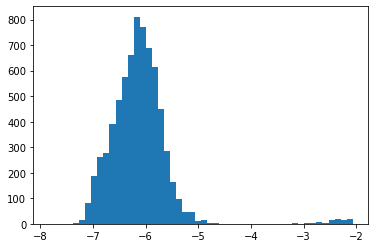

In [126]:
plt.hist(np.log10(full_lyapunov[100000000]), bins=50)

/tmp/ipykernel_10113/2494021343.py:4: RuntimeWarning: invalid value encountered in log10
  d = np.log10(full_lyapunov[100000000].to_numpy())


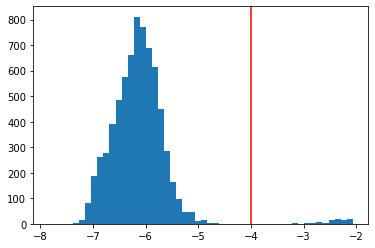

In [133]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

d = np.log10(full_lyapunov[100000000].to_numpy())
# clean data from infs and nan
d = d[np.isfinite(d)]
d = d[np.logical_not(np.isnan(d))]

labels = KMeans(n_clusters=2, random_state=42).fit_predict(d.reshape(-1, 1))
max_1 = np.max(d[labels == 0])
max_2 = np.max(d[labels == 1])
min_1 = np.min(d[labels == 0])
min_2 = np.min(d[labels == 1])
if max_1 > max_2:
    thresh_1 = (max_2 + min_1) / 2
else:
    thresh_1 = (max_1 + min_2) / 2

plt.hist(d, bins=50)
plt.axvline(thresh_1, color="r")

/tmp/ipykernel_10113/1982299959.py:1: RuntimeWarning: invalid value encountered in log10
  d = np.log10(full_lyapunov[100000000].to_numpy())


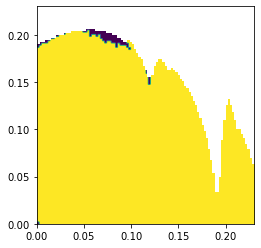

In [137]:
d = np.log10(full_lyapunov[100000000].to_numpy())
d = np.asarray(d <= thresh_1, dtype=float)
d[~stab_mask] = np.nan
plt.imshow(d.reshape(samples, samples), origin="lower", extent=X_EXTENTS+Y_EXTENTS)

ground_truth = d

In [139]:
values_lyap = Parallel(n_jobs=njobs)(
    delayed(dm.get_full_comparison)(
        np.log10(lyapunov[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ) for t in times_minor
)

th_best_lyap = np.asarray([v["accuracy_best_val"] for v in values_lyap])
th_chosen_lyap = np.asarray([v["threshold"] for v in values_lyap])

ac_best_lyap = np.asarray([v["accuracy_best"] for v in values_lyap])
ac_chosen_lyap = np.asarray([v["accuracy_threshold"] for v in values_lyap])


/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [140]:
values_olyap_max = Parallel(n_jobs=njobs)(
    delayed(dm.get_full_comparison)(
        np.log10(ortho_lyap_max[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ) for t in times_minor
)

th_best_olyap_max = np.asarray([v["accuracy_best_val"] for v in values_olyap_max])
th_chosen_olyap_max = np.asarray([v["threshold"] for v in values_olyap_max])

ac_best_olyap_max = np.asarray([v["accuracy_best"] for v in values_olyap_max])
ac_chosen_olyap_max = np.asarray([v["accuracy_threshold"] for v in values_olyap_max])


In [141]:
values_olyap_avg = Parallel(n_jobs=njobs)(
    delayed(dm.get_full_comparison)(
        np.log10(ortho_lyap_avg[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ) for t in times_minor
)

th_best_olyap_avg = np.asarray([v["accuracy_best_val"] for v in values_olyap_avg])
th_chosen_olyap_avg = np.asarray([v["threshold"] for v in values_olyap_avg])

ac_best_olyap_avg = np.asarray([v["accuracy_best"] for v in values_olyap_avg])
ac_chosen_olyap_avg = np.asarray([v["accuracy_threshold"] for v in values_olyap_avg])


In [142]:
values_sali = Parallel(n_jobs=njobs)(
    delayed(dm.get_full_comparison)(
        np.log10(sali[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=True,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ) for t in times_minor
)

th_best_sali = np.asarray([v["accuracy_best_val"] for v in values_sali])
th_chosen_sali = np.asarray([v["threshold"] for v in values_sali])

ac_best_sali = np.asarray([v["accuracy_best"] for v in values_sali])
ac_chosen_sali = np.asarray([v["accuracy_threshold"] for v in values_sali])


/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [143]:
values_gali = Parallel(n_jobs=njobs)(
    delayed(dm.get_full_comparison)(
        np.log10(gali[t].to_numpy()),
        ground_truth == 1,
        stable_if_higher=True,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ) for t in times_minor
)

th_best_gali = np.asarray([v["accuracy_best_val"] for v in values_gali])
th_chosen_gali = np.asarray([v["threshold"] for v in values_gali])

ac_best_gali = np.asarray([v["accuracy_best"] for v in values_gali])
ac_chosen_gali = np.asarray([v["accuracy_threshold"] for v in values_gali])


In [144]:
values_reverse = Parallel(n_jobs=njobs)(
    delayed(dm.get_full_comparison)(
        np.log10(reverse[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ) for t in times_minor
)

th_best_reverse = np.asarray([v["accuracy_best_val"] for v in values_reverse])
th_chosen_reverse = np.asarray([v["threshold"] for v in values_reverse])

ac_best_reverse = np.asarray([v["accuracy_best"] for v in values_reverse])
ac_chosen_reverse = np.asarray([v["accuracy_threshold"] for v in values_reverse])


In [145]:
values_tunes = Parallel(n_jobs=njobs)(
    delayed(dm.get_full_comparison)(
        np.log10(tunes[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ) for t in times_tune[:-2]
)

th_best_tunes = np.asarray([v["accuracy_best_val"] for v in values_tunes])
th_chosen_tunes = np.asarray([v["threshold"] for v in values_tunes])

ac_best_tunes = np.asarray([v["accuracy_best"] for v in values_tunes])
ac_chosen_tunes = np.asarray([v["accuracy_threshold"] for v in values_tunes])


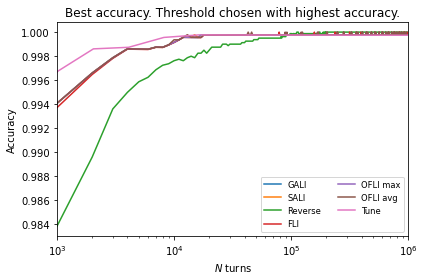

In [155]:
fig, ax = plt.subplots(1, 1)

ax.plot(times_minor, ac_best_gali, label="GALI")
ax.plot(times_minor, ac_best_sali, label="SALI")
ax.plot(times_minor, ac_best_reverse, label="Reverse")
ax.plot(times_minor, ac_best_lyap, label="FLI")
ax.plot(times_minor, ac_best_olyap_max, label="OFLI max")
ax.plot(times_minor, ac_best_olyap_avg, label="OFLI avg")
ax.plot(times_tune[5:-2], ac_best_tunes[5:], label="Tune")

ax.legend(ncol=2, fontsize="small")
ax.set_xscale("log")

ax.set_xlim(1e3, 1e6)
ax.set_xlabel("$N$ turns")
ax.set_ylabel("Accuracy")

ax.set_title("Best accuracy. Threshold chosen with highest accuracy.")
plt.tight_layout()

In [153]:
times_tune[5:-2]

array([    512,    1024,    2048,    4096,    8192,   16384,   32768,
         65536,  131072,  262144,  524288, 1048576])